In [1]:
# turn of warnings
import warnings
warnings.filterwarnings("ignore")

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from stargazer.stargazer import Stargazer
from scipy.optimize import minimize

In [51]:
# paths 
overleaf_path = '/Users/veronica/Dropbox/Apps/Overleaf/EC_731_vcperez_overleaf/PSET_2'

# Data

In [90]:
df = pd.read_excel('dvddataEC732.xls')

In [91]:
df.head()

,month,sales,price,mp3,coax
0,446,714,945,0,1.0
1,446,14,434,0,0.0
2,446,1253,727,0,1.0
3,446,1082,489,0,1.0
4,446,341,1515,0,1.0


# Cleaning up

In [54]:
# make missing values in mp3 and coax zero
df['mp3'] = df['mp3'].fillna(0)
df['coax'] = df['coax'].fillna(0)

This problem asks you to estimate a model of dynamic demand for DVD players based on the model of Melnikov (2013) (linked under the Course Readings on the class web page). Download the data set dvdDataEC732.xls from the class web page. The data set contains average price and total sales for DVD players at the level of the model-month from March 1997 to September 1998. It also has two characteristics, indicator variables for whether the player has the ability play MP3 files and whether it uses coaxial cable. Think of these as two quality measures. For these variables, convert missing values to zero. Note that the month variable is a number ranging from 446 to 464 . Using the command format month \%tmmY in Stata converts the month variable to the appropriate text.
You may find Melinikov's paper difficult to follow. I provide a step-bystep guide that I want you to follow. In Melnikov's model, consumers may purchase once and only once in their lifetime. Consumers obtain $\delta_{j t}+\varepsilon_{i j t}$ from purchase where $\varepsilon_{i j t}$ is distributed Extreme Value and:

$$
\delta_{j t}=x_j \beta-\alpha \ln \left(p_{j t}\right)+\xi_{j t}
$$


The value of purchasing at $t$ is given by the variable $v_{i t}$ which is equal to $r_t+\varepsilon_{i t}^{\prime}$ where $\varepsilon_{i t}^{\prime}$ is distributed Extreme Value and $r_t$ is the "logit inclusive value:"

$$
r_t=\ln \left(\sum_{j \in J_t} e^{\delta_{j t}}\right)
$$

The dynamic part of the problem can be thought of as simply the choice of whether or not to buy in a period. The expected value of buying is $r_t$. Waiting earns the consumer flow utility $c+\varepsilon_{i 0 t}$ (where $\varepsilon_{i 0 t} \sim E V$ ) and the option to buy at future values of $r_t$. Melnikov assumes that $r_t$ is a Markov process and that consumers predict $r_{t+1}$ using $r_t$ only. Therefore, there is a single state variable $r_t$. The Bellman equation is:

$$
V\left(r_t\right)=\ln \left(e^{r_t}+e^{c+\beta E\left[V\left(r_{t+1}\right) \mid r_t\right]}\right)
$$

Part (a) relies on following results: Let $s_{j t}$ equal the share of all potential consumers that buy $j$ in $t$. Let $s_t$ be the share of all potential consumers that buy in period $t$. That is, $\sum_j s_{j t}=s_t$ and $\sum_t s_t \leq 1$. Let $s_{0 t}$ be the share of all people who have not bought at the end of period $t$. That is, $s_{0 t}=1-\sum_1^t s_t$. Let $W_t=c+\beta E\left[V\left(r_{t+1}\right) \mid r_t\right]$, the value of waiting. We know that $s_{j t}=s_{0 t-1} \exp \left(\delta_{j t}\right) /\left(\exp \left(W_t\right)+\exp \left(r_t\right)\right)$ and that $s_t=$ $s_{0 t-1} \exp \left(r_t\right) /\left(\exp \left(W_t\right)+\exp \left(r_t\right)\right)$. Therefore, $s_{j t} / s_t=\exp \left(\delta_{j t}\right) / \exp \left(r_t\right)$
Melnikov proposes a three-step procedure to estimate demand.


In [55]:
df.head()

,month,sales,price,mp3,coax
0,446,714,945,0,1.0
1,446,14,434,0,0.0
2,446,1253,727,0,1.0
3,446,1082,489,0,1.0
4,446,341,1515,0,1.0


## Making VAriables 

In [ ]:
# get potential costumers - confusing he only says this in D but okay
potential_customers  = df['sales'].sum()

# get s_jt = share of total sales in month t for each product j
df["s_jt"] = df["sales"] /potential_customers

# s_t = sum_over_j(s_jt) = share of total sales in month t
df["s_t"] = df.groupby("month")["s_jt"].transform("sum")

# ln(s_jt / s_t) = ln(s_jt) - ln(s_t)
df['ln_sjt_st'] = np.log(df['s_jt'] / df['s_t'])


In [58]:
df.head()

,month,sales,price,mp3,coax,s_jt,s_t,ln_sjt_st
0,446,714,945,0,1.0,0.001767,0.01441,-2.098688
1,446,14,434,0,0.0,0.000035,0.01441,-6.030514
2,446,1253,727,0,1.0,0.003101,0.01441,-1.536275
3,446,1082,489,0,1.0,0.002678,0.01441,-1.683004
4,446,341,1515,0,1.0,0.000844,0.01441,-2.837688


# A) 

Estimate $\ln \left(s_{j t} / s_t\right)=\delta_{j t}-r_t$ where $r_t$ is captured by a full set of time dummies (do not include a constant term in $x_j$ ). For this step, assume all variables are exogenous, including price. Provide a table of your results for estimates of coefficients on $x_j$ and a brief discussion of the major results from this stage.

$\delta_{j t}=x_j \beta-\alpha \ln \left(p_{j t}\right)+\xi_{j t}$

In [ ]:
# all numeric columns are float
df_reg = df.copy()
df_reg['log_price'] = np.log(df_reg['price'].astype(float))

# make dummies - drop_first=False to get all dummies
month_dummies = pd.get_dummies(df_reg['month'],prefix='month' ,drop_first=False, dtype=float)

# check nas
month_dummies = month_dummies.fillna(0)

# make indep vars
X = df_reg[['mp3', 'coax', 'log_price']].astype(float)
X = pd.concat([X, month_dummies], axis=1)

# Dep var
Y = df_reg['ln_sjt_st']
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

In [138]:
# Create a Stargazer object with the filtered regression results
stargazer = Stargazer([results])

# keep only relevant variables
stargazer.covariate_order(['coax', 'mp3','log_price'])

# rename log price
stargazer.rename_covariates({'log_price': 'log(price)'})

# rename dep var
stargazer.dependent_variable_name("ln(s_{jt}/s_{t})")

# add text 
stargazer.add_line("Month FE", ["YES"])


# Generate the LaTeX code
latex_code = stargazer.render_latex()

# Save the LaTeX code to a file
with open(overleaf_path + "/pset2_q1a.tex", "w") as f:
    f.write(latex_code)

### (b) 
Estimate the equation $r_{t+1}=\alpha_0+\alpha_1 r_t+\nu_{t+1}$. Report your coefficients. Discretize the state space into 20 evenly spaced bins from -1 to 3 . (See me if you find values of $r_t$ that do not fit in this range.) Construct a transition matrix based on your estimates of $\alpha$ for how the state space evolves over time. Graph $r_t$. Does it seem that your estimates well capture this process?
A citation for discretizing a Markov process is Tauchen (1986). If you don't feel comfortable with discretizing the AR1, you may just use the empirical frequency for how the state evolves. That is, find the probability that $r_t$ jumps 1 state or 2 states etc. and fill in the transition matrix that way. Either way, make sure that each row of your transition matrix sums to 1 .

In [111]:
# estimate r_t_+1_
rt_df = pd.DataFrame()
# month dummies caputres r_t for each period

rt_df["r_t"] = -results.params[3:]

# Sort the dataframe by the new datetime index
rt_df = rt_df.sort_index()

# Display the updated dataframe
rt_df

# make rt+1
rt_df["r_t_plus_1"] = rt_df["r_t"].shift(-1) 

# drop last row
rt_df = rt_df.dropna()

# make vars for AR1 
# add constant for reg
X = sm.add_constant(rt_df["r_t"]) 
Y = rt_df["r_t_plus_1"]

# OLS
ar1_model = sm.OLS(Y, X)
ar1_results = ar1_model.fit()

print(ar1_results.summary())

alpha_0 = ar1_results.params[0]

alpha_1 = ar1_results.params[1]

sigma_v = np.sqrt(ar1_results.mse_resid)

print(f"alpha_0: {alpha_0}")
print(f"alpha_1: {alpha_1}")
print(f"sigma_v: {sigma_v}")

                            OLS Regression Results                            
Dep. Variable:             r_t_plus_1   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     184.2
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           3.39e-10
Time:                        23:23:37   Log-Likelihood:                 6.4272
No. Observations:                  18   AIC:                            -8.854
Df Residuals:                      16   BIC:                            -7.074
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1151      0.065      1.760      0.0

In [112]:
# export r_t results

# Create a Stargazer object with the filtered regression results
stargazer = Stargazer([ar1_results])

# rename dep var
stargazer.dependent_variable_name("r_{t+1}")


# Generate the LaTeX code
latex_code = stargazer.render_latex()

# Save the LaTeX code to a file
with open(overleaf_path + "/pset2_q1b.tex", "w") as f:
    f.write(latex_code)

In [113]:
stargazer

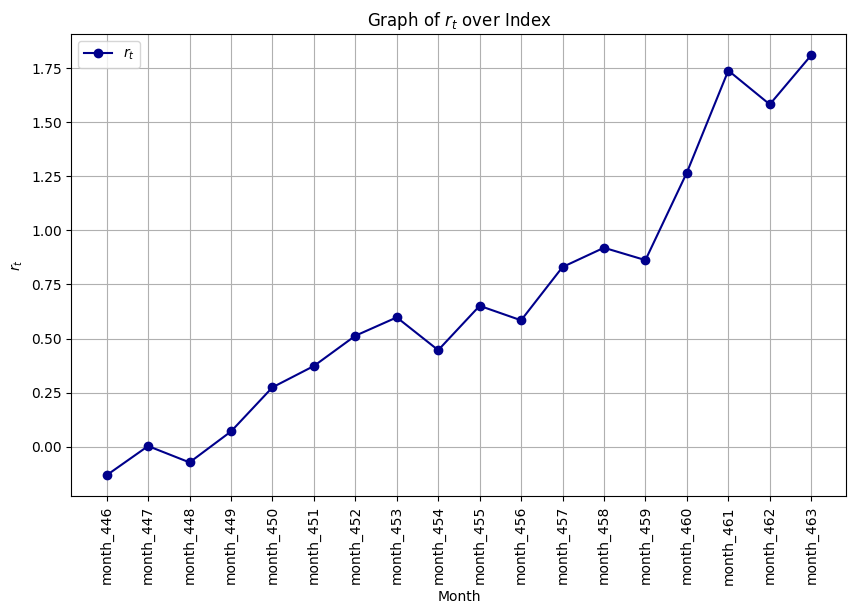

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(rt_df.index, rt_df["r_t"], marker='o', linestyle='-', color='#00008B', label='$r_t$')
plt.xlabel("Month")
plt.ylabel("$r_t$")
plt.title("Graph of $r_t$ over Index")
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.grid(True)
plt.savefig(overleaf_path + "/pset2_q2b.png", dpi=300)
plt.show()

### discretize state spacem

In [ ]:
r_t_values = rt_df["r_t"].values

# check if all r_t values are within [-1, 3]
if not all((-1 <= r <= 3) for r in r_t_values):
    print("Warning: Some r_t values outside [-1, 3] range!")
    print("Min:", min(r_t_values), "Max:", max(r_t_values))

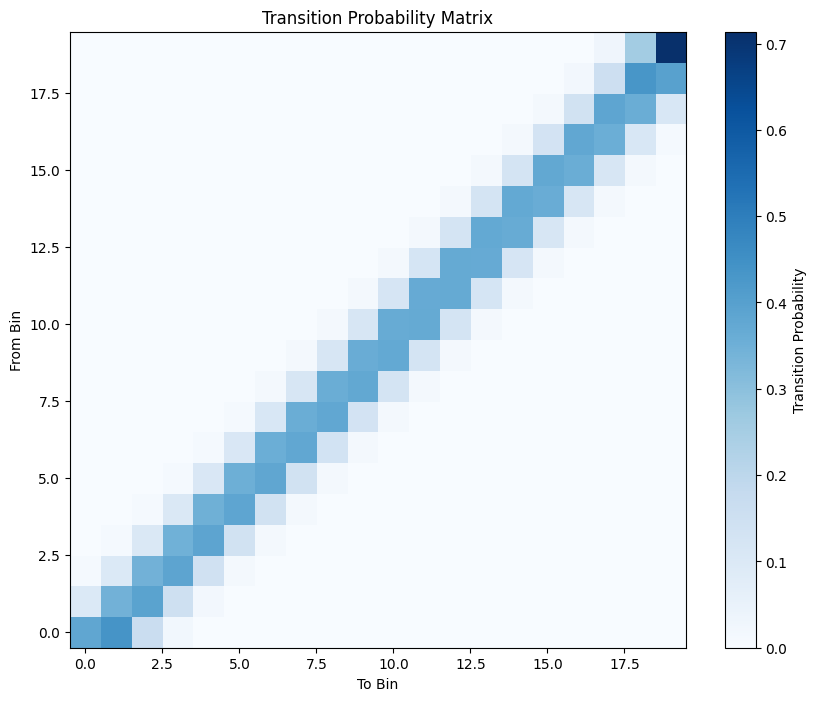


AR(1) Process Characteristics:
Persistence (α₁): 0.989
Long-run mean: 10.465
Standard deviation of shocks: 0.180


In [144]:
n_bins = 20

# tauchen method for transition matrix
def tauchen(alpha0, alpha1, sigma, n_bins, min_val, max_val):
    bin_edges = np.linspace(min_val, max_val, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    transition = np.zeros((n_bins, n_bins))
    
    for i in range(n_bins):
        mean = alpha0 + alpha1 * bin_centers[i]
        for j in range(n_bins):
            # Probability of transitioning from i to j
            lower = (bin_edges[j] - mean) / sigma
            upper = (bin_edges[j+1] - mean) / sigma
            transition[i,j] = norm.cdf(upper) - norm.cdf(lower)
        # Normalize row to sum to 1
        transition[i,:] /= transition[i,:].sum()
    
    return transition, bin_centers

# use transition from tauchen
transition, bin_centers = tauchen(alpha_0, alpha_1, sigma_v, n_bins, -1, 3)

# Visualization of transition matrix with inverse Christmas colors
plt.figure(figsize=(10, 8))
plt.imshow(transition, cmap='Blues', origin='lower')  # Green-Red colormap for inverse Christmas theme
plt.colorbar(label='Transition Probability')
plt.xlabel('To Bin')
plt.ylabel('From Bin')
plt.title('Transition Probability Matrix')
plt.savefig(overleaf_path + "/pset2_q1b_2.png", dpi=300)
plt.show()

# More detailed assessment
print("\nAR(1) Process Characteristics:")
print(f"Persistence (α₁): {alpha_1:.3f}")
print(f"Long-run mean: {alpha_0/(1-alpha_1):.3f}" if alpha_1 < 1 else "Non-stationary process")
print(f"Standard deviation of shocks: {sigma_v:.3f}")

## (c)

(c) For $c=0$, construct the value function by solving the Bellman equation above via a fixed-point algorithm. Use a discount rate of $\beta=0.99$. It is not obvious what to use for $e^{r_t}$ because the state space is discretized. You may use the mid-point of each bin. Graph $V\left(r_t\right)$ as a function of $r_t$. Does $V\left(r_t\right)$ take on the shape you expected?

Converged after 190 iterations


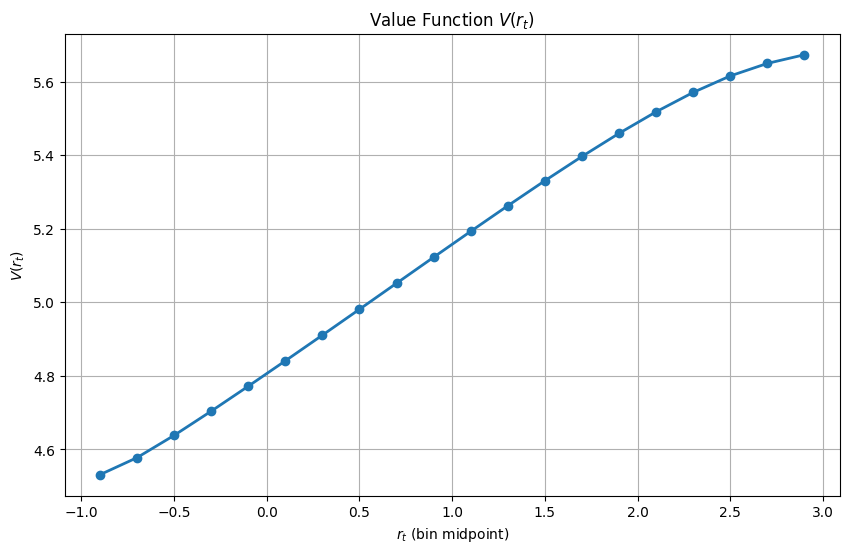

In [134]:
# ger parameters
beta = 0.99       # discount rate
c = 0             # glow utility of waiting
n_bins = 20       # bins
tol = 1e-6        # tolerance
max_iter = 1000   # maximum iterations

# bin midpoints (from part b)
bin_edges = np.linspace(-1, 3, n_bins + 1)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# start value function
V = np.zeros(n_bins)

# fixed-point iteration
for iter in range(max_iter):
    V_new = np.zeros(n_bins)
    for i in range(n_bins):
        # Expected future value: sum over possible next states
        EV = np.sum(transition[i, :] * V)
        
        # Bellman update
        V_new[i] = np.log(np.exp(bin_midpoints[i]) + np.exp(beta * EV))
    
    # Check for convergence
    if np.max(np.abs(V_new - V)) < tol:
        print(f"Converged after {iter} iterations")
        break
    
    V = V_new.copy()
else:
    print("Warning: Did not converge within max iterations")

# Plot V(r_t)
plt.figure(figsize=(10, 6))
plt.plot(bin_midpoints, V, 'o-', linewidth=2)
plt.xlabel("$r_t$ (bin midpoint)")
plt.ylabel("$V(r_t)$")
plt.title("Value Function $V(r_t)$")
plt.grid(True)
plt.savefig(overleaf_path+"/pset2_q1c.png", dpi=300)
plt.show()

## (d) Estimate $c$ via Maximum Likelihood. Use the empirical likelihood function:

$$
\max _c l(c)=\sum_{t=1}^{T+1} \ln \left(\hat{s}_t\right) s_t
$$

where $\hat{s}_t$ is the prediction of the model, and $s_{T+1}$ is the share of households that never purchase (so $s_{T+1}=s_{0 T}$ ). For the potential market, use $100,000,000$, which is about the number of households in the U.S. during this time period. Report your estimate of $c$. Graph actual market shares and predicted market shares over time. Comment on the results and possible shortcomings of the model.

In [124]:
# get observed share
observed_shares = df.groupby('month')['sales'].sum() / 100000000

# define never buys
s_never_buy = max(0, 1 - observed_shares.sum())

# cehck
print(f"Observed shares sum: {observed_shares.sum():.4f}, Never buy: {s_never_buy:.4f}")

# get ll
def log_likelihood(c, V, transition, bin_midpoints, observed_shares, beta=0.99):
    try:
        # compute value function for current c
        V_c = value_function_iteration(c, bin_midpoints, transition, beta)
        
        # start variables
        pred_shares = np.zeros(len(observed_shares) + 1)
        remaining_share = 1.0
        total_ll = 0.0
        
        # Compute shares period by period
        for t in range(len(observed_shares)):
            # Current state index (find nearest bin)
            state_idx = np.argmin(np.abs(bin_midpoints - (-results.params[3+t])))
            
            # Compute choice probability with log-sum-exp
            W_t = c + beta * np.sum(transition[state_idx, :] * V_c)
            max_val = max(bin_midpoints[state_idx], W_t)
            prob_buy = np.exp(bin_midpoints[state_idx] - max_val) / \
                      (np.exp(bin_midpoints[state_idx] - max_val) + np.exp(W_t - max_val))
            
            pred_shares[t] = remaining_share * prob_buy
            total_ll += observed_shares.iloc[t] * np.log(pred_shares[t] + 1e-300)
            remaining_share *= (1 - prob_buy)
        
        # add never-buy component
        pred_shares[-1] = remaining_share
        total_ll += s_never_buy * np.log(pred_shares[-1] + 1e-300)
        
        return -total_ll  # Return negative for minimization
    
    except:
        return np.inf  # Return infinity if numerical error occurs

# Value function iteration - different function for MLE
def value_function_iteration(c, bin_midpoints, transition, beta, tol=1e-8, max_iter=1000):
    
    V = np.log(np.exp(bin_midpoints) + 1) 
    for _ in range(max_iter):
        EV = transition @ V
        # Log-sum-exp trick
        max_vals = np.maximum(bin_midpoints, c + beta * EV)
        V_new = max_vals + np.log(np.exp(bin_midpoints - max_vals) + 
                                 np.exp(c + beta * EV - max_vals))
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new
    return V

# Optimization setup
#  grid search to find good region --  i was having issues optimizing
c_grid = np.linspace(-0.5, 0.5, 50)
ll_grid = [log_likelihood(c, V, transition, bin_midpoints, observed_shares) 
           for c in c_grid]
best_c_grid = c_grid[np.argmin(ll_grid)]

# refine with bounded optimization
result = minimize(
    log_likelihood,
    x0=best_c_grid,
    args=(V, transition, bin_midpoints, observed_shares),
    method='L-BFGS-B',
    bounds=[(-1, 1)],  # Reasonable bounds for flow utility
    options={'maxiter': 100, 'ftol': 1e-8}
)
# extract c
c_estimated = result.x[0]
print(f"\nEstimated c: {c_estimated:.6f}")
print(f"Negative log-likelihood: {result.fun:.4f}")
print(f"Optimization success: {result.success}")

Observed shares sum: 0.0040, Never buy: 0.9960

Estimated c: 0.092987
Negative log-likelihood: 0.0380
Optimization success: True


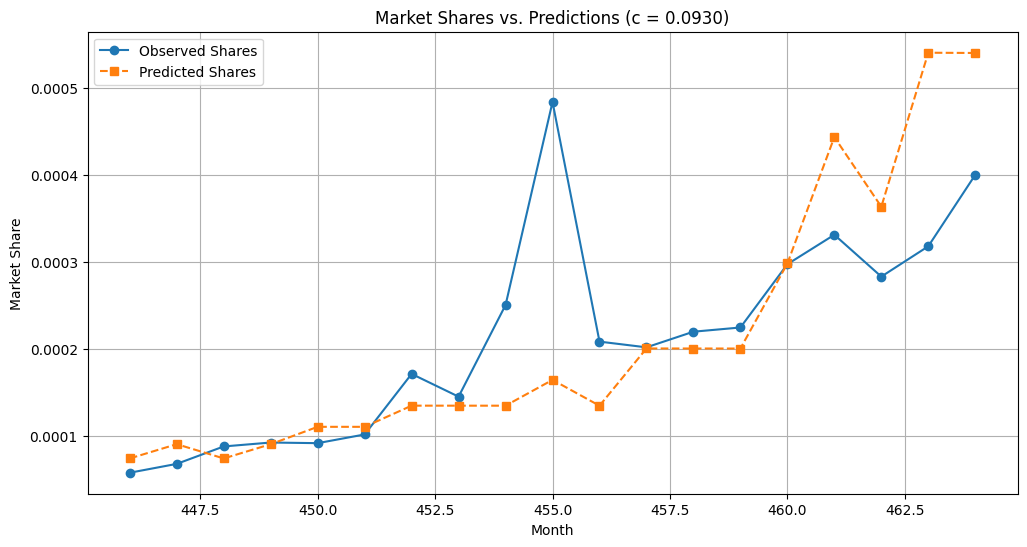

In [135]:
# get predicted shares at estimated c
def compute_predicted_shares(c, V, transition, bin_midpoints, observed_shares):
    V_c = value_function_iteration(c, bin_midpoints, transition, beta)
    pred_shares = []
    remaining = 1.0
    
    for t in range(len(observed_shares)):
        state_idx = np.argmin(np.abs(bin_midpoints - (-results.params[3+t])))
        W_t = c + beta * np.sum(transition[state_idx, :] * V_c)
        prob_buy = np.exp(bin_midpoints[state_idx]) / (np.exp(bin_midpoints[state_idx]) + np.exp(W_t))
        share_t = remaining * prob_buy
        pred_shares.append(share_t)
        remaining *= (1 - prob_buy)
    
    return np.array(pred_shares)

predicted_shares = compute_predicted_shares(c_estimated, V, transition, bin_midpoints, observed_shares)

# 6. Visualization and analysis
plt.figure(figsize=(12, 6))
months = df['month'].unique()
plt.plot(months, observed_shares, 'o-', label='Observed Shares')
plt.plot(months, predicted_shares, 's--', label='Predicted Shares')
plt.title(f'Market Shares vs. Predictions (c = {c_estimated:.4f})')
plt.xlabel('Month')
plt.ylabel('Market Share')
plt.legend()
plt.grid(True)
plt.savefig(overleaf_path+"/pset2_q1d.png", dpi=300)
plt.show()
